In [40]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping


In [41]:
DATA_DIR = 'Train'

def load_data(target_size=(32, 32)):
    images, labels = [], []
    for class_id in os.listdir(DATA_DIR):
        class_path = os.path.join(DATA_DIR, class_id)
        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, target_size)
                images.append(img)
                labels.append(int(class_id))
    return np.array(images), np.array(labels)


In [ ]:
# 32x32 for Custom CNN
X_32, y_32 = load_data(target_size=(32, 32))
X_32 = X_32 / 255.0
y_32 = LabelBinarizer().fit_transform(y_32)
X_train_32, X_test_32, y_train_32, y_test_32 = train_test_split(X_32, y_32, test_size=0.2, random_state=42)

# 224x224 for EfficientNet
X_224, y_224 = load_data(target_size=(224, 224))
y_224 = LabelBinarizer().fit_transform(y_224)  
X_train_224, X_test_224, y_train_224, y_test_224 = train_test_split(X_224, y_224, test_size=0.2, random_state=42)


In [43]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_custom_model(input_shape, num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

custom_model = build_custom_model((32, 32, 3), y_32.shape[1])
custom_model.summary()


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_14 (Conv2D)              │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 319,979 (1.22 MB)

 Trainable params: 319,979 (1.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
datagen_32 = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen_32.fit(X_train_32)

early_stop = EarlyStopping(patience=3)

custom_model.fit(
    datagen_32.flow(X_train_32, y_train_32, batch_size=32),
    validation_data=(X_test_32, y_test_32),
    epochs=15,
    callbacks=[early_stop]
)


custom_model.save("model/custom_cnn.h5")


Epoch 1/15


C:\Users\Acer\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


981/981 ━━━━━━━━━━━━━━━━━━━━ 16s 15ms/step - accuracy: 0.1732 - loss: 3.0572 - val_accuracy: 0.6197 - val_loss: 1.2226
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.4893 - loss: 1.5963 - val_accuracy: 0.7775 - val_loss: 0.7312
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.6038 - loss: 1.1975 - val_accuracy: 0.8662 - val_loss: 0.4383
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.6837 - loss: 0.9628 - val_accuracy: 0.9033 - val_loss: 0.3370
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7252 - loss: 0.8258 - val_accuracy: 0.9334 - val_loss: 0.2493
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - accuracy: 0.7609 - loss: 0.7197 - val_accuracy: 0.9570 - val_loss: 0.1741
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.7828 - loss: 0.6577 - val_accuracy: 0.9526 - val_loss: 0.1618
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - accuracy: 0.8019 - loss: 0.5920 - val_accurac

In [45]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D

def build_efficientnet_model(num_classes):
    base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
    base_model.trainable = False

    inputs = Input(shape=(224, 224, 3))
    x = preprocess_input(inputs)
    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

efficientnet_model = build_efficientnet_model(y_224.shape[1])
efficientnet_model.summary()


Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 43)             │         5,547 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,219,086 (16.09 MB)

 Trainable params: 169,515 (662.17 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
datagen_224 = ImageDataGenerator(preprocessing_function=preprocess_input)

efficientnet_model.fit(
    datagen_224.flow(X_train_224, y_train_224, batch_size=32),
    validation_data=(X_test_224, y_test_224),
    epochs=15,
    callbacks=[early_stop]
)


efficientnet_model.save("model/efficientnet_model.h5")


Epoch 1/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 934s 944ms/step - accuracy: 0.6495 - loss: 1.2543 - val_accuracy: 0.9114 - val_loss: 0.3028
Epoch 2/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 957s 976ms/step - accuracy: 0.9040 - loss: 0.3082 - val_accuracy: 0.9416 - val_loss: 0.1948
Epoch 3/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 942s 960ms/step - accuracy: 0.9370 - loss: 0.2023 - val_accuracy: 0.9569 - val_loss: 0.1376
Epoch 4/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 928s 946ms/step - accuracy: 0.9545 - loss: 0.1470 - val_accuracy: 0.9603 - val_loss: 0.1235
Epoch 5/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 900s 917ms/step - accuracy: 0.9594 - loss: 0.1269 - val_accuracy: 0.9656 - val_loss: 0.1111
Epoch 6/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 893s 911ms/step - accuracy: 0.9648 - loss: 0.1087 - val_accuracy: 0.9644 - val_loss: 0.1100
Epoch 7/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 897s 914ms/step - accuracy: 0.9692 - loss: 0.0939 - val_accuracy: 0.9765 - val_loss: 0.0747
Epoch 8/15
981/981 ━━━━━━━━━━━━━━━━━━━━ 897s 914ms/step - accuracy: 0.9749 -

In [ ]:
from sklearn.metrics import accuracy_score


y_pred_cnn = np.argmax(custom_model.predict(X_test_32), axis=1)
y_true_cnn = np.argmax(y_test_32, axis=1)

y_pred_eff = np.argmax(efficientnet_model.predict(X_test_224), axis=1)
y_true_eff = np.argmax(y_test_224, axis=1)

print("Custom CNN Accuracy:", accuracy_score(y_true_cnn, y_pred_cnn))
print("EfficientNet Accuracy:", accuracy_score(y_true_eff, y_pred_eff))


246/246 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
246/246 ━━━━━━━━━━━━━━━━━━━━ 173s 696ms/step
Custom CNN Accuracy: 0.9839326702371843
EfficientNet Accuracy: 0.9744963019637848


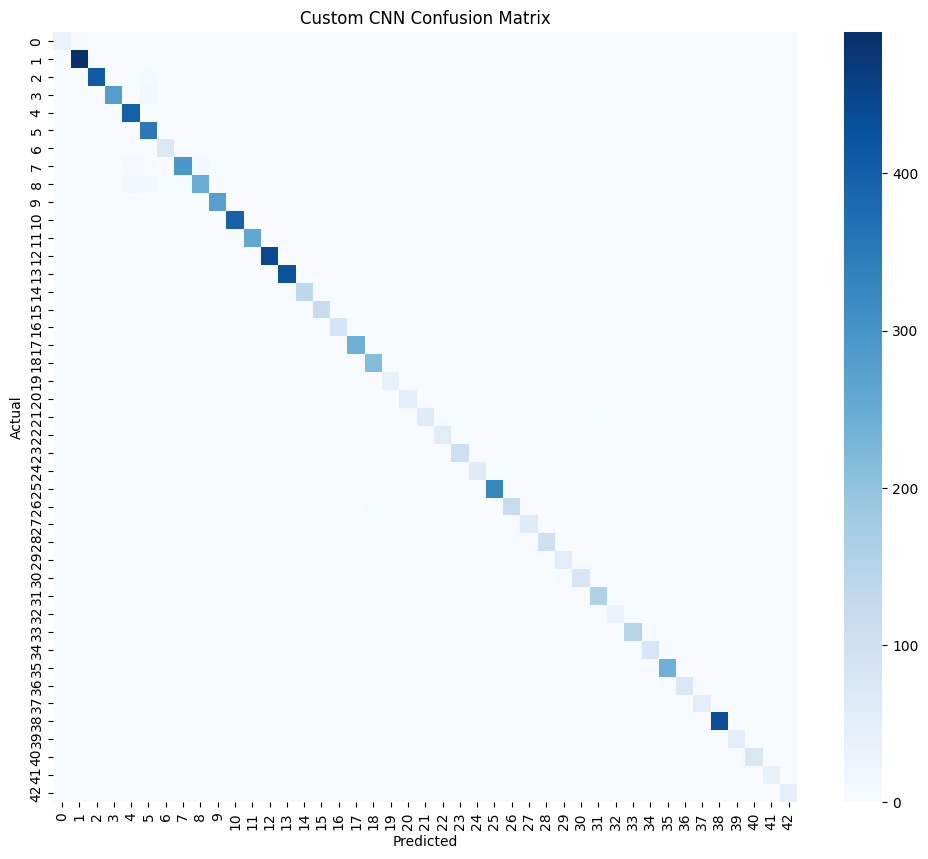

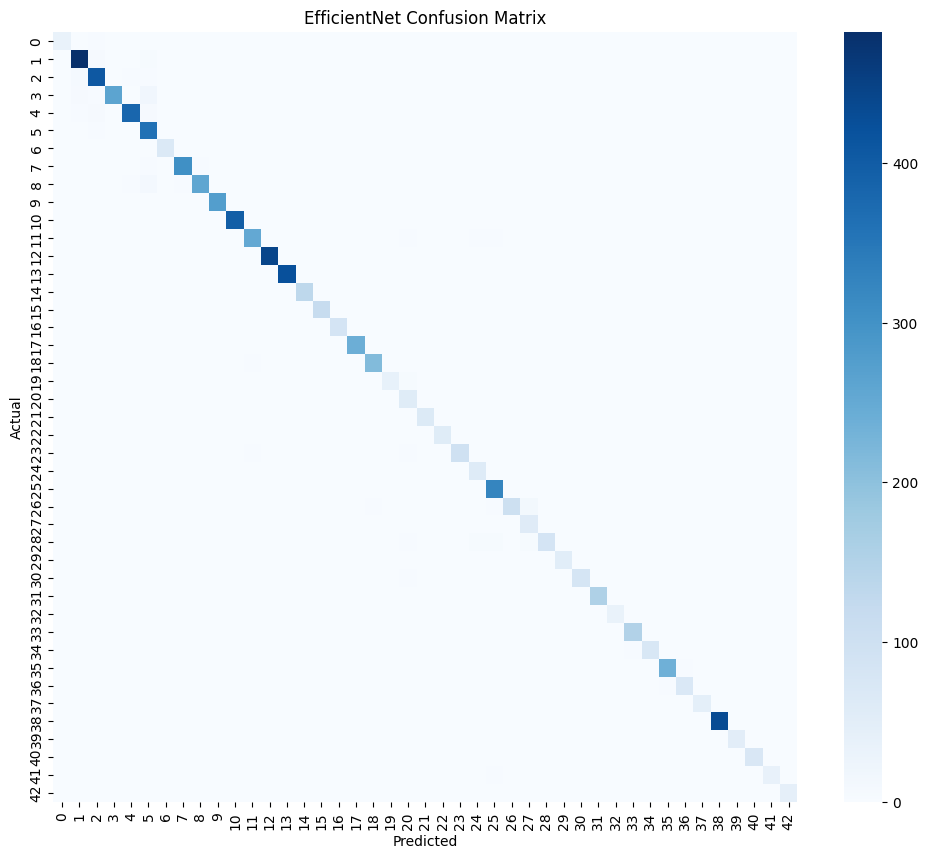

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=False, cmap="Blues")
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

plot_confusion(y_true_cnn, y_pred_cnn, "Custom CNN Confusion Matrix")
plot_confusion(y_true_eff, y_pred_eff, "EfficientNet Confusion Matrix")


In [ ]:
import tkinter as tk
from tkinter import filedialog
from PIL import Image, ImageTk
import numpy as np
import cv2
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess


custom_model = load_model("model/custom_cnn.h5")
efficientnet_model = load_model("model/efficientnet_model.h5")

selected_image_path = None


def predict(model, input_size=(32, 32), preprocess=lambda x: x / 255.0):
    if selected_image_path:
        img = cv2.imread(selected_image_path)
        img = cv2.resize(img, input_size)
        img = preprocess(img)
        img = np.expand_dims(img, axis=0)

        prediction = model.predict(img)
        predicted_class = np.argmax(prediction)
        confidence = np.max(prediction) * 100
        result_label.config(text=f"Predicted Class: {predicted_class}\nConfidence: {confidence:.2f}%")
    else:
        result_label.config(text="Please select an image.")


def choose_image():
    global selected_image_path
    path = filedialog.askopenfilename()
    if path:
        selected_image_path = path
        img = Image.open(path)
        img = img.resize((150, 150))
        img = ImageTk.PhotoImage(img)
        image_label.config(image=img)
        image_label.image = img
        result_label.config(text="")


root = tk.Tk()
root.title("Traffic Sign Classifier")
root.geometry("400x450")

tk.Button(root, text="Choose Image", command=choose_image).pack(pady=10)

image_label = tk.Label(root)
image_label.pack()

tk.Button(root, text="Predict with Custom CNN", command=lambda: predict(custom_model, (32, 32), lambda x: x / 255.0)).pack(pady=5)
tk.Button(root, text="Predict with EfficientNet", command=lambda: predict(efficientnet_model, (224, 224), efficientnet_preprocess)).pack(pady=5)

result_label = tk.Label(root, text="", font=("Arial", 12))
result_label.pack(pady=20)

root.mainloop()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
